# Opdracht classificatie 1 - logistic regression

Logistische regressie is een bijzonder populaire classificatietechniek. Enerzijds door zijn eenvoud en relatief lage eisen die het stelt in termen van rekenkracht. In veel gevallen is de performantie qua accuracy vergelijkbaar (en soms beter) dan gecompliceerdere algoritmes zoals de support vector machines.
Daarnaast heeft logistische regressie het voordeel dat het getrainde model een voorspelling doet in termen van de kans dat de input tot een bepaalde klasse behoort. Uit deze kans kan je afleiden hoe overtuigd het model is van de gemaakte voorspelling.

Het is de bedoeling om via enkele classificatieopdrachten inzicht te verkrijgen in:
- Correct trainen en het uitvoeren van hyperparameter tuning bij logistische regressie.
- Classificaties kunnen uitvoeren via logistische regressie.
- Feature engineering uitvoeren.
- Interpreteren van de verschillende performance metrics: accuracy, recall, precision, f1-score, ROC.
- Kunnen omgaan met niet-gebalanceerde data en het kunnen regelen tussen het aantal false positives en false negatives. 
- Weten wanneer je te maken hebt met overfitting en underfitting en de juiste bijstellingen kunnen doen.


In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn import preprocessing
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression
import seaborn as sns

## Opdracht 1: Diabetes

Het bestand *diabetes.csv* bevat medische gegevens van meer dan 300 personen waarbij telkens geweten is of de persoon al dan niet diabetes heeft.
Train nu een logic regression model dat op basis van de features een zo goed mogelijke predictie kan doen of iemand al dan niet diabetes heeft.

### Inlezen van de dataset en vooranalyse

In [2]:
# inlezen van de dataset
dataset = pd.read_csv('diabetes.csv')
dataset.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


Controleer of de dataset inconsistenties of foute waarden bevat. Gebruik listwise deletion. Dit betekent dat je alle gegevens van een persoon uit de dataset verwijdert van zodra er 1 feature foutief is of ontbreekt.

In [3]:
# inconsistenties opsporen
dataset.isnull().sum()
# dataset.isna().any().any()
# neen, er zijn geen ontbrekende waarden

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

Neen, er zijn geen ontbrekende waarden

Bepaal de verdeling van het aantal personen met diabetes ten opzichte van het aantal personen zonder. Is de dataset gebalanceerd?

In [4]:
# gebalanceerdheid controleren
diabetesPositive = dataset.loc[dataset['Outcome'] == 1].count()
diabetesNegative = dataset.loc[dataset['Outcome'] == 0].count()
print(diabetesPositive)
print(diabetesNegative)

Pregnancies                 268
Glucose                     268
BloodPressure               268
SkinThickness               268
Insulin                     268
BMI                         268
DiabetesPedigreeFunction    268
Age                         268
Outcome                     268
dtype: int64
Pregnancies                 500
Glucose                     500
BloodPressure               500
SkinThickness               500
Insulin                     500
BMI                         500
DiabetesPedigreeFunction    500
Age                         500
Outcome                     500
dtype: int64


Neen, de dataset is niet gebalanceerd. In totaal zijn er 768 personen waarvan 268 diabetes (positief) en 500 geen diabetes hebben (negatief).

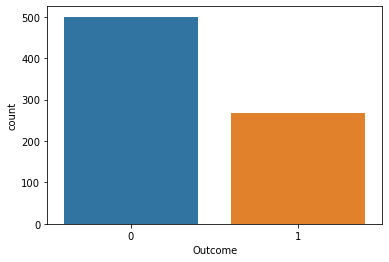

In [5]:
# visuele verdeling outcome
sns.countplot(x='Outcome', data=dataset)

Bepaal de statistische kerngetallen van de verschillende features en target. Gebruik hiervoor de *describe* functie.

In [6]:
# statistische kerngetallen
dataset.describe()
# Om outliers te vinden kijken naar mean en std en mogelijke dummy variabelen verwijderen wanneer een kolom veel 0 waarden bevat.

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [7]:
dataset.corr()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
Pregnancies,1.000000,0.129459,0.141282,-0.081672,-0.073535,0.017683,-0.033523,0.544341,0.221898
Glucose,0.129459,1.000000,0.152590,0.057328,0.331357,0.221071,0.137337,0.263514,0.466581
BloodPressure,0.141282,0.152590,1.000000,0.207371,0.088933,0.281805,0.041265,0.239528,0.065068
SkinThickness,-0.081672,0.057328,0.207371,1.000000,0.436783,0.392573,0.183928,-0.113970,0.074752
Insulin,-0.073535,0.331357,0.088933,0.436783,1.000000,0.197859,0.185071,-0.042163,0.130548
BMI,0.017683,0.221071,0.281805,0.392573,0.197859,1.000000,0.140647,0.036242,0.292695
DiabetesPedigreeFunction,-0.033523,0.137337,0.041265,0.183928,0.185071,0.140647,1.000000,0.033561,0.173844
Age,0.544341,0.263514,0.239528,-0.113970,-0.042163,0.036242,0.033561,1.000000,0.238356
Outcome,0.221898,0.466581,0.065068,0.074752,0.130548,0.292695,0.173844,0.238356,1.000000


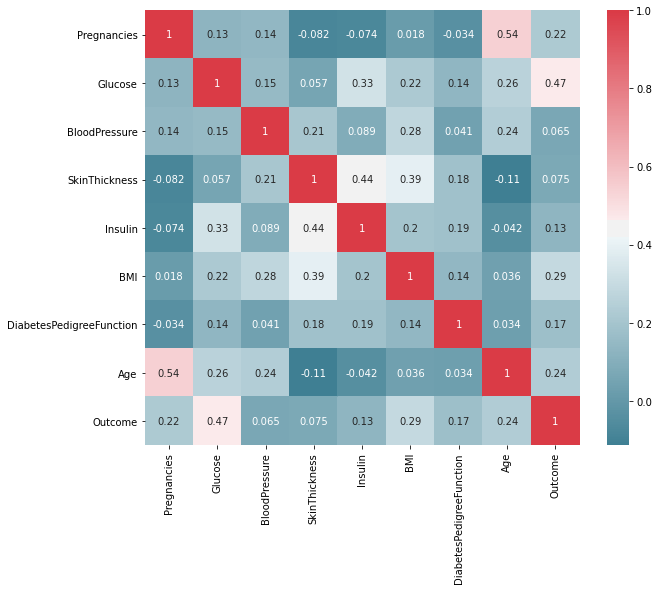

In [8]:
# Lineaire correlatie tussen de features - heatmap
dataset.corr()
# Visualiseer de onderlinge correlatiecoëfficiënten
f, ax = plt.subplots(figsize=(10,8))
corr = dataset.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax,annot=True)

### Preprocessing en opsplitsen van de dataset

Splits de dataset in **features en targets**.

In [9]:
# Opsplitsen in features en targets
#features = list(dataset.columns[:dataset.columns.size-1])

#X = dataset[features].values
#y = dataset['Outcome'].values

X = dataset.drop(['Outcome'], axis=1).values
y = dataset['Outcome'].values



Creëer een **trainingset en een testset**. Zorg dat er 100 patiënten in de testset steken. 

In [10]:
# training set en test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=100, random_state=0)


**Schaal de dataset**. Zorg er dus voor dat de features op een gelijke schaalverdeling staan. Voor het scalen kan gebruik gemaakt worden van de *preprocessing.StandardScaler()*. Meer info over het gebruik ervan is te vinden op http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html

In [11]:
# Scaling
scaler = preprocessing.StandardScaler().fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)


### Trainen van een logistic regression classifier en testen van het bekomen model

Train een logistic regression classifier op de training data. Kies C=1 als startwaarde. Mocht de dataset niet gebalanceerd zijn (de ene klasse komt frequenter voor dan de andere klasse) dan kan je bij de creatie van het logistic regression model de parameter class_weight='balanced' meegeven. Meer info: http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

Test het getrainde model op de test set. Bepaal hierbij de confusion matrix, de accuracy en het classification report. Wat zijn de bevindingen? Probeer ook verschillende solvers uit. Bepaal ook telkens de ROC en formuleer conclusies.

Probeer de performantie van de classifier te verhogen door de parameter C te veranderen.

Evalueer de modellen telkens via de confusion matrix, classification report en indien mogelijk via de ROC-curve. Bespreek de resultaten.

In [12]:
# hyperparameter tuning
# trainen van de logistic regression classifier model 1
logreg = linear_model.LogisticRegression(C=1, class_weight='balanced', solver='liblinear')
logreg.fit(X_train,y_train)
print('coefficiënten: ', logreg.coef_)
print('intercept:', logreg.intercept_)


coefficiënten:  [[ 0.37310983  1.01872499 -0.24264303  0.03596544 -0.13329186  0.75956642
   0.34760506  0.269486  ]]
intercept: [-0.23930493]


In [13]:
# testen van de logistic regression classifier

y_pred = logreg.predict(X_test)

# classification report
print(classification_report(y_test, y_pred))

# accuracy
print(accuracy_score(y_test,y_pred)*100)

# confusion matrix
print(confusion_matrix(y_test,y_pred))


              precision    recall  f1-score   support

           0       0.89      0.72      0.80        69
           1       0.57      0.81      0.67        31

    accuracy                           0.75       100
   macro avg       0.73      0.77      0.73       100
weighted avg       0.79      0.75      0.76       100

75.0
[[50 19]
 [ 6 25]]


- De precision bedraagt 89% voor klasse 0 en 57% voor klasse 1.


- De recall bedraagt 72% voor klasse 0 en 81% voor klasse 1. De recall is de percentage dat men ontdekt heeft van de klasse.


- Het gewogen gemiddelde van de recall en de precision is de F1 score. 
- De F1 bedraagt 80% voor klasse 0 en 67% voor klasse 1


- De accuracy bedraagt 75%, dit betekent dat in 75% gevallen de classifier correct is voorspelt.


Confusion matrix:
- De test set bedraagt in totaal 100 samples, dit kunnen we terug lezen in de support kolom. Vervolgens gaan we dit trainen om een voorspelling te maken.
- Diagonaal zijn er 2 waarden namelijk 50 (klasse 0) en 25 (klasse 1). In totaal bedraagt het 75 waarden die correct zijn voorspelt (TP en TN).
- 6 van de 100 samples is door het model voorspelt behorende tot klasse 0 , maar in werkelijkheid behorend tot klasse 1.
- 19 van de 100 samples is  door het model voorspelt behorende tot klasse 1, maar in werkelijkheid behorend tot klasse 0.

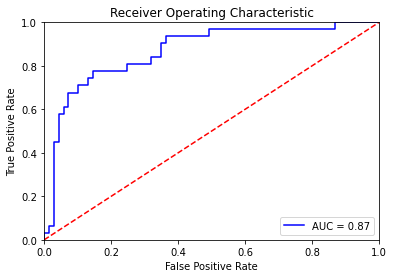

In [14]:
# ROC
# classifier te evalueren op eeng rafische methode
import sklearn.metrics as metrics
# calculate the fpr and tpr for all tresholds of the classification
probs = logreg.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

De AUC bedraagt 87%, dit is niet slecht. Het ideale is tussen 0.90-1 en dit kan eventueel door C te veranderen om de performantie van de classifier te verhogen. Hoe dichter de curve dichter komt bij ROC heaven, des te meer accuraat.

In [15]:
# trainen van de logistic regression classifier 
# model 2
logreg = linear_model.LogisticRegression(C=0.0001, class_weight='balanced')
logreg.fit(X_train,y_train)
print('coefficiënten: ', logreg.coef_)
print('intercept:', logreg.intercept_)

coefficiënten:  [[0.00714797 0.01536313 0.00196187 0.0028817  0.00408643 0.01052379
  0.00574268 0.00805324]]
intercept: [-0.00470683]


In [16]:
# testen van de logistic regression classifier

y_pred = logreg.predict(X_test)

# classification report
print(classification_report(y_test, y_pred))
# accuracy
print(accuracy_score(y_test,y_pred)*100)
# confusion matrix
print(confusion_matrix(y_test,y_pred))



              precision    recall  f1-score   support

           0       0.87      0.80      0.83        69
           1       0.62      0.74      0.68        31

    accuracy                           0.78       100
   macro avg       0.75      0.77      0.75       100
weighted avg       0.80      0.78      0.78       100

78.0
[[55 14]
 [ 8 23]]


- De precision bedraagt 87% voor klasse 0 en 62% voor klasse 1.


- De recall bedraagt 80% voor klasse 0 en 74% voor klasse 1. De recall is de percentage dat men ontdekt heeft van de klasse.


- Het gewogen gemiddelde van de recall en de precision is de F1 score. 
- De F1 bedraagt 83% voor klasse 0 en 68% voor klasse 1


- De accuracy bedraagt 78%, dit betekent dat in 78% gevallen de classifier correct is voorspelt.


Confusion matrix:
- De test set bedraagt in totaal 100 samples, dit kunnen we terug lezen in de support kolom. Vervolgens gaan we dit trainen om een voorspelling te maken.
- Diagonaal zijn er 2 waarden namelijk 55 (klasse 0) en 23 (klasse 1). In totaal bedraagt het 78 waarden die correct zijn voorspelt (TP en TN).
- 8 van de 100 samples is door het model voorspelt behorende tot klasse 0 , maar in werkelijkheid behorend tot klasse 1.
- 14 van de 100 samples is  door het model voorspelt behorende tot klasse 1, maar in werkelijkheid behorend tot klasse 0.

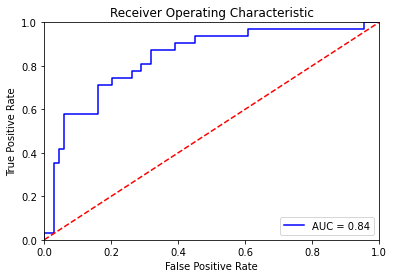

In [17]:
# ROC
# classifier te evalueren op eeng rafische methode
import sklearn.metrics as metrics
# calculate the fpr and tpr for all tresholds of the classification
probs = logreg.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


De AUC bedraagt 84%, dit is niet slecht. Het ideale is tussen 0.90-1 en dit kan eventueel door C te veranderen om de performantie van de classifier te verhogen. Hoe dichter de curve dichter komt bij ROC heaven, des te meer accuraat.

Door de parameter C te veranderen hebben we het model kunnen verbeteren. Aan de hand van de confusion matrix kunnen we besluiten dat er een lichte stijging is van correcte voorspelde waarden en dat de accuracy ook gestegen is met 3%.

### Feature engineering
Creeër hogere orde features door gebruik te maken van *preprocessing.PolynomialFeatures*. Meer info is te vinden op http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html

Deze functie zal automatische hogere orde features aanmaken door het combineren van de aanwezige features. Heb je bijvoorbeeld drie features, zijnde A, B en C dan worden bij de keuze van een derde orde PolynomialFeatures volgende nieuwe features bijgemaakt:
$A^3, B^3,C^3,A^2B,A^2C,AB^2, B^2C,...$

Experimenteer met verschillende ordes en gebruik de regularisatieparameter C om de performantie te verhogen. Voor indien nodig ook regularisatie uit via een L1 of L2 penalty.

**Opgepast**: het kiezen van een te hoge orde zorgt voor een exponentiële toename aan features waardoor de logistic regression classifier niet meer binnen aanvaardbare tijd getraind kan worden. Advies is om niet hoger te gaan dan 4de orde.

In [18]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

# Aanmaken van de hogere orde features
graad = 4

poly = PolynomialFeatures(graad)
Xp = poly.fit_transform(X)


# Train model op hogere orde features 

logreg_poly = linear_model.LogisticRegression(C=1)
logreg_poly.fit(Xp, y)

X_train_poly = poly.transform(X_train)
X_test_poly = poly.transform(X_test)
print('dimensie van X_train_poly: ',X_train_poly.shape)
print('dimensie van X_test_poly: ',X_test_poly.shape)

# met L2 regularisatie via Ridge regression
logregmodel_poly = Ridge(alpha=1500,tol=0.0001,fit_intercept=True)
logregmodel_poly.fit(X_train_poly,y_train)

print('R2 score via L2: ',logregmodel_poly.score(X_test_poly,y_test))
# R2 -score via L2 op de trainingset
print('R2 score op training set via L2: ',logregmodel_poly.score(X_train_poly,y_train))


# met L1 regularisatie via Lasso regression
logregmodel_poly = Lasso(alpha=0.03,tol=0.0001,fit_intercept=True)
logregmodel_poly.fit(X_train_poly,y_train)      
  
      
print('R2 score via L1: ',logregmodel_poly.score(X_test_poly,y_test))
  
# R2 -score via L1 op de trainingset
print('R2 score op training set via L1: ',logregmodel_poly.score(X_train_poly,y_train))    
  


C:\Users\Dominic Ho\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


dimensie van X_train_poly:  (668, 495)
dimensie van X_test_poly:  (100, 495)
R2 score via L2:  0.09334395943928364
R2 score op training set via L2:  0.4431482374036503
R2 score via L1:  0.2662657120554499
R2 score op training set via L1:  0.38193315361435676


C:\Users\Dominic Ho\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0380974193057142, tolerance: 0.015291467065868262
  model = cd_fast.enet_coordinate_descent(


Wat zijn de bevindingen? Formuleer een conclusie. Bespreek hierin de performantie van de getrainde modellen. Wat is de invloed van de parameter C en van het aantal features? Heb je te maken gehad met underfitting en overfitting en hoe heb je dit bepaald? Welke accuracy werd bekomen en hoe zit het met de Recall en Precision? Is de grootte van de trainingset voldoende?

Antwoord: Om te bepalen of het model te maken heeft met underfitting of overfitting heb ik de L1 en L2 regularisatie toegepast. In het algemeen scoren de R2 hoger op de training set dan de test set dus hebben we te maken met een overfitting. Vervolgens bedraagt de accuracy 78% op het aangepaste model met een nieuwe C parameter. Dit betekent dat in 78% gevallen de classifier correct is voorspelt. De Recall en Precision waarden van 87% en 80% doen het beter voor klasse 0 in vergelijking met klasse 1  met de waarden 62% en 74%. Omdat we beiden waarden niet kunnen verbeteren, is het best om de F1 score te gebruiken. De F1 score is het gewogen gemiddelde van Precision and Recall en voor klasse 0 bedraagt het 83% en klasse 1 68%.

Dit betekent dat het model een voorkeur heeft voor klasse 0 en het algemeen goed doet.

Oplossing: 
- Meer data verzamelen van de minderheidsklasse



### Voorspel aan de hand van het getrainde model

Voorspel of iemand met onderstaande medische parameters als dan niet diabetes heeft. Geef ook de zekerheid van het model weer (kansen dat de patiënt tot een bepaalde klasse behoort).

Pregnancies: 2 -
Glucose: 132 -
BloodPressure: 74 - 
SkinThickness: 20 - 
Insulin: 21 - 
BMI: 24.3 - 
DiabetesPedigreeFunction: 128 - 
Age: 37

In [19]:
# voorspelling
person = np.array([2,132,74,20,21,24.3,1.28,37])

outcome = logreg.predict(person.reshape(1,-1))
print('Het resultaat van de uitkomst is: ', outcome)
print('kans op geen diabetes/diabetes',logreg.predict_proba(np.array([2,132,74,20,21,24.3,1.28,37]).reshape(1,-1)))

Het resultaat van de uitkomst is:  [1]
kans op geen diabetes/diabetes [[0.05279005 0.94720995]]


Standaard zal het model een sample toewijzen aan klasse 1 van zodra de probiliteit boven de threshold van 50% uisteekt. 
Men wil echter de kans op false negatives drastisch verminderen door het aanpassen van de threshold. Welke threshold moet men instellen om ervoor te zorgen dat het model op de test set geen false negatives meer voorspelt en toch nog een zo hoog mogelijke accuraatheid heeft?
Stel het aantal false negatives in functie van de threshold grafisch voor. Bespreek de resultaten.

- Geen code gevonden in de cursus om de treshold aan te passen, kan geen oplossing geven.

## Opdracht 2. Human resources

Een groot bedrijf probeert te voorspellen of een werknemer binnenkort al dan niet het bedrijf zal verlaten en hoopt zo tijdig te kunnen ingrijpen.
Gebruik logistische regressie op de dataset 'Human_Resources.csv' om een zo accuraat mogelijk model te trainen. 
Tevens wil het bedrijf vooral false negatives vermijden.
Welke zijn de top 3 features die het sterkst bepalen of een werknemer het bedrijf zal verlaten?

De dataset bestaat uit de volgende features:

- satisfaction_level: mate van voldoening op het werk.
- last_evaluationTime: aantal jaar sinds de laatste evaluatie.
- number_project: het aantal projecten die de werknemer op het bedrijf heeft afgewerkt.
- average_montly_hours: het aantal uur die de werknemer gemiddeld per maand aanwezig is op de werkplaats.
- time_spend_company: het aantal jaar in dienst van het bedrijf.
- work_accident: of de werknemer al een werkongeval heeft gehad.
- promotion_last_5years: of de werknemer al dan niet een promotie heeft gehad de afgelopen 5 jaar.
- department: het departement waar de werknemer voor werkt.
- salary: relatief loon (low, medium, high).

De te voorspellen target = left: of de werknemer het bedrijf al dan niet heeft verlaten (0 of 1)

Gebruik one-hot encoding om categorische features om te zetten naar one-hot features.

Evalueer telkens via de confusion matrix, classification report en ROC-curve. Zorg voor een test set die uit 25% van de volledige dataset bestaat.

Voorspel de kans dat volgende werknemer het bedrijf zal verlaten: 
satisfaction level = 0.54; 
last_evaluation = 0.73;
number_project = 3;
averag_montly_hours = 270;
time_spend_company = 6;
work_accident = 1;
promotion_last_5years = 0;
departments =  technical;
salary = low

### Inlezen van de dataset en vooranalyse

In [20]:
dataset = pd.read_csv('Human_Resources.csv')
print('Dimensie van de dataset:',dataset.shape)
dataset.head()

Dimensie van de dataset: (14999, 10)


,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,work_accident,left,promotion_last_5years,department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


In [21]:
# one hot encoding de laatste 2 kolommen (categorische features: department en salary)

dataset = pd.concat([dataset,pd.get_dummies(dataset['department'])],axis=1)
dataset.drop(['department'],axis=1, inplace=True)
dataset = pd.concat([dataset,pd.get_dummies(dataset['salary'])],axis=1)
dataset.drop(['salary'],axis=1, inplace=True)
dataset.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,work_accident,left,promotion_last_5years,IT,RandD,...,hr,management,marketing,product_mng,sales,support,technical,high,low,medium
0,0.38,0.53,2,157,3,0,1,0,0,0,...,0,0,0,0,1,0,0,0,1,0
1,0.80,0.86,5,262,6,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,1
2,0.11,0.88,7,272,4,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,1
3,0.72,0.87,5,223,5,0,1,0,0,0,...,0,0,0,0,1,0,0,0,1,0
4,0.37,0.52,2,159,3,0,1,0,0,0,...,0,0,0,0,1,0,0,0,1,0


In [22]:
# inconsistenties opsporen
dataset.isnull().sum()

#dataset.isna().any().any()
# neen, er zijn geen ontbrekende waarden

satisfaction_level       0
last_evaluation          0
number_project           0
average_montly_hours     0
time_spend_company       0
work_accident            0
left                     0
promotion_last_5years    0
IT                       0
RandD                    0
accounting               0
hr                       0
management               0
marketing                0
product_mng              0
sales                    0
support                  0
technical                0
high                     0
low                      0
medium                   0
dtype: int64

Neen, er zijn geen ontbrekende waarden.

In [23]:
# gebalanceerdheid controleren
positive = dataset.loc[dataset['left'] == 1].count()
negative = dataset.loc[dataset['left'] == 0].count()
print(positive)
print(negative)

satisfaction_level       3571
last_evaluation          3571
number_project           3571
average_montly_hours     3571
time_spend_company       3571
work_accident            3571
left                     3571
promotion_last_5years    3571
IT                       3571
RandD                    3571
accounting               3571
hr                       3571
management               3571
marketing                3571
product_mng              3571
sales                    3571
support                  3571
technical                3571
high                     3571
low                      3571
medium                   3571
dtype: int64
satisfaction_level       11428
last_evaluation          11428
number_project           11428
average_montly_hours     11428
time_spend_company       11428
work_accident            11428
left                     11428
promotion_last_5years    11428
IT                       11428
RandD                    11428
accounting               11428
hr              

Neen, de dataset is niet gebalanceerd. In totaal zijn er 14999 personen waarvan 3571 personen het bedrijf heeft verlaten en 11428 in het bedrijf zijn.

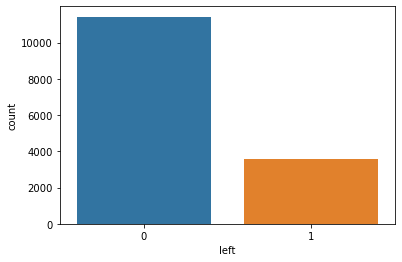

In [24]:
# visuele verdeling outcome
sns.countplot(x='left', data=dataset)

In [25]:
# statistische kerngetallen
dataset.describe()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,work_accident,left,promotion_last_5years,IT,RandD,...,hr,management,marketing,product_mng,sales,support,technical,high,low,medium
count,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,...,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000
mean,0.612834,0.716102,3.803054,201.050337,3.498233,0.144610,0.238083,0.021268,0.081805,0.052470,...,0.049270,0.042003,0.057204,0.060137,0.276018,0.148610,0.181345,0.082472,0.487766,0.429762
std,0.248631,0.171169,1.232592,49.943099,1.460136,0.351719,0.425924,0.144281,0.274077,0.222981,...,0.216438,0.200602,0.232239,0.237749,0.447041,0.355715,0.385317,0.275092,0.499867,0.495059
min,0.090000,0.360000,2.000000,96.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.440000,0.560000,3.000000,156.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.640000,0.720000,4.000000,200.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.820000,0.870000,5.000000,245.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000
max,1.000000,1.000000,7.000000,310.000000,10.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [26]:
dataset.corr()[['left']].sort_values(by='left', ascending = False)

,left
left,1.000000
time_spend_company,0.144822
low,0.134722
average_montly_hours,0.071287
hr,0.028249
number_project,0.023787
technical,0.020076
accounting,0.015201
support,0.010700
sales,0.009923


Welke zijn de top 3 features die het sterkst bepalen of een werknemer het bedrijf zal verlaten?

De top 3 features zijn:
- time_spend_company
- satification_level
- work_accident

### Preprocessing en opsplitsen van de dataset

Splits de dataset in **features en targets**.

In [27]:
# Opsplitsen in features en targets
X = dataset.drop(['left'], axis=1).values
y = dataset['left'].values
print(X)
print(y)


[[0.38 0.53 2.   ... 0.   1.   0.  ]
 [0.8  0.86 5.   ... 0.   0.   1.  ]
 [0.11 0.88 7.   ... 0.   0.   1.  ]
 ...
 [0.37 0.53 2.   ... 0.   1.   0.  ]
 [0.11 0.96 6.   ... 0.   1.   0.  ]
 [0.37 0.52 2.   ... 0.   1.   0.  ]]
[1 1 1 ... 1 1 1]


Creëer een **trainingset en een testset**. 

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)


**Schaal de dataset**. 

In [29]:
# Scaling

scaler = preprocessing.StandardScaler().fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

### Trainen van een logistic regression classifier en testen van het bekomen model

Train een logistic regression classifier op de training data. Kies C=1 als startwaarde. Mocht de dataset niet gebalanceerd zijn (de ene klasse komt frequenter voor dan de andere klasse) dan kan je bij de creatie van het logistic regression model de parameter class_weight='balanced' meegeven. Meer info: http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

Test het getrainde model op de test set. Bepaal hierbij de confusion matrix, de accuracy en het classification report. Wat zijn de bevindingen? Probeer ook verschillende solvers uit. Bepaal ook telkens de ROC en formuleer conclusies.

Probeer de performantie van de classifier te verhogen door de parameter C te veranderen.

Evalueer de modellen telkens via de confusion matrix, classification report en indien mogelijk via de ROC-curve. Bespreek de resultaten.

In [30]:
# hyperparameter tuning
# trainen van de logistic regression classifier model 1
logreg = linear_model.LogisticRegression(C=1, class_weight='balanced', solver='liblinear')
logreg.fit(X_train,y_train)
print('coefficiënten: ', logreg.coef_)
print('intercept:', logreg.intercept_)

coefficiënten:  [[-1.09938659  0.19436148 -0.51339705  0.25008939  0.70555972 -0.516957
  -0.2139254  -0.04843947 -0.11157548  0.00749945  0.05648095 -0.10002651
  -0.00411509 -0.00983168  0.01447816  0.04732997  0.06371513 -0.39603425
   0.23653248 -0.01938948]]
intercept: [-0.49806503]


In [31]:
# testen van de logistic regression classifier

y_pred = logreg.predict(X_test)

# classification report
print(classification_report(y_test, y_pred))

# accuracy
print(accuracy_score(y_test,y_pred)*100)

# confusion matrix
print(confusion_matrix(y_test,y_pred))


              precision    recall  f1-score   support

           0       0.93      0.74      0.83      2881
           1       0.49      0.83      0.62       869

    accuracy                           0.76      3750
   macro avg       0.71      0.78      0.72      3750
weighted avg       0.83      0.76      0.78      3750

76.10666666666667
[[2134  747]
 [ 149  720]]


- De precision bedraagt 93% voor klasse 0 en 49% voor klasse 1.


- De recall bedraagt 74% voor klasse 0 en 83% voor klasse 1. De recall is de percentage dat men ontdekt heeft van de klasse.


- Het gewogen gemiddelde van de recall en de precision is de F1 score. 
- De F1 bedraagt 83% voor klasse 0 en 62% voor klasse 1


- De accuracy bedraagt 76%, dit betekent dat in 76% gevallen de classifier correct is voorspelt.


Confusion matrix:
- De test set bedraagt in totaal 3750 samples (25%), dit kunnen we terug lezen in de support kolom. Vervolgens gaan we dit trainen om een voorspelling te maken.
- Diagonaal zijn er 2 waarden namelijk 2134 (klasse 0) en 720 (klasse 1). In totaal bedraagt het 2854 waarden die correct zijn voorspelt.
- 149 van de 3750 samples is door het model voorspelt behorende tot klasse 0 , maar in werkelijkheid behorend tot klasse 1.
- 747 van de 3750 samples is  door het model voorspelt behorende tot klasse 1, maar in werkelijkheid behorend tot klasse 0.

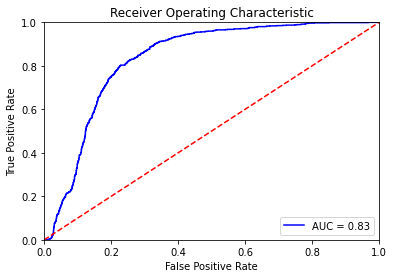

In [32]:
# reduceren van het aantal false negatives door de threshold aan te passen

# ROC
import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification
probs = logreg.predict_proba(X_test)

preds = probs[:,1]

fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

De AUC bedraagt 83%, dit is niet slecht. Het ideale is tussen 0.90-1 en dit kan eventueel door C te veranderen om de performantie van de classifier te verhogen. Hoe dichter de curve dichter komt bij ROC heaven, des te meer accuraat.

In [33]:
# hyperparameter tuning
# trainen van de logistic regression classifier model 2
logreg = linear_model.LogisticRegression(C=0.1, class_weight='balanced')
logreg.fit(X_train,y_train)
print('coefficiënten: ', logreg.coef_)
print('intercept:', logreg.intercept_)

coefficiënten:  [[-1.08946429  0.19005406 -0.50404388  0.24614882  0.69711975 -0.51186847
  -0.21113674 -0.04808304 -0.11090887  0.00756609  0.05624763 -0.09913803
  -0.00410094 -0.00982201  0.0145597   0.04690027  0.06298958 -0.39189941
   0.23491353 -0.02004592]]
intercept: [-0.49244555]


In [34]:
# testen van de logistic regression classifier

y_pred = logreg.predict(X_test)

# classification report
print(classification_report(y_test, y_pred))
# accuracy
print(accuracy_score(y_test,y_pred)*100)
# confusion matrix
print(confusion_matrix(y_test,y_pred))


              precision    recall  f1-score   support

           0       0.93      0.74      0.83      2881
           1       0.49      0.83      0.62       869

    accuracy                           0.76      3750
   macro avg       0.71      0.78      0.72      3750
weighted avg       0.83      0.76      0.78      3750

76.13333333333333
[[2135  746]
 [ 149  720]]


- De precision bedraagt 93% voor klasse 0 en 49% voor klasse 1.


- De recall bedraagt 74% voor klasse 0 en 83% voor klasse 1. De recall is de percentage dat men ontdekt heeft van de klasse.


- Het gewogen gemiddelde van de recall en de precision is de F1 score. 
- De F1 bedraagt 83% voor klasse 0 en 62% voor klasse 1


- De accuracy bedraagt 76%, dit betekent dat in 76% gevallen de classifier correct is voorspelt.


Confusion matrix:
- De test set bedraagt in totaal 3750 samples (25%), dit kunnen we terug lezen in de support kolom. Vervolgens gaan we dit trainen om een voorspelling te maken.
- Diagonaal zijn er 2 waarden namelijk 2135 (klasse 0) en 720 (klasse 1). In totaal bedraagt het 2854 waarden die correct zijn voorspelt.
- 149 van de 3750 samples is door het model voorspelt behorende tot klasse 0 , maar in werkelijkheid behorend tot klasse 1.
- 746 van de 3750 samples is  door het model voorspelt behorende tot klasse 1, maar in werkelijkheid behorend tot klasse 0.

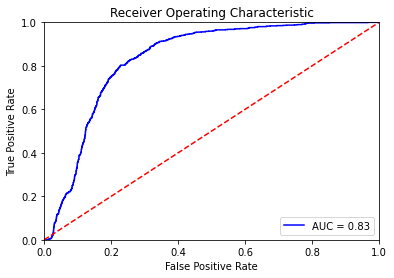

In [35]:
# reduceren van het aantal false negatives door de threshold aan te passen

# ROC
import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification
probs = logreg.predict_proba(X_test)

preds = probs[:,1]

fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

De AUC bedraagt 83%, dit is niet slecht. Het ideale is tussen 0.90-1 en dit kan eventueel door C te veranderen om de performantie van de classifier te verhogen. Hoe dichter de curve dichter komt bij ROC heaven, des te meer accuraat.

Het model is zeer stabiel gebleven bij het veranderen van de parameter C. We zien geen grote veranderingen, alleen een stijging van 1 sample bij correct voorspelde waarden in de confusion matrix. Vervolgens blijft de accuracy op 76%.

### Voorspel aan de hand van het getrainde model

Voorspel de kans dat volgende werknemer het bedrijf zal verlaten: 


satisfaction level = 0.54; 
last_evaluation = 0.73;
number_project = 3;
averag_montly_hours = 270;
time_spend_company = 6;
work_accident = 1;
promotion_last_5years = 0;
departments =  technical;
salary = low

In [36]:
# voorspelling
person = np.array([0.54,0.73,3,270,6,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0])
print(person)

left = logreg.predict(person.reshape(1,-1))
print('Het resultaat van de uitkomst is: ', left)
print('kans op verlaten/niet verlaten',logreg.predict_proba(np.array([0.54,0.73,3,270,6,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0]).reshape(1,-1)))

[  0.54   0.73   3.   270.     6.     1.     0.     0.     0.     0.
   0.     0.     0.     0.     0.     0.     1.     0.     1.     0.  ]
Het resultaat van de uitkomst is:  [1]
kans op verlaten/niet verlaten [[0. 1.]]


De werknemer zal het bedrijf verlaten met een kans van 100%


## Opdracht 3.  Star Wars

Train een logistic regression classifier aan de hand van de dataset 'StarWars.csv') om te voorspellen of iemand al dan niet een Star Wars fan is.
Gebruik one-hot encondig waar nodig. Zorg ervoor dat de test set uit minstens 200 samples bestaat.
Evalueer de getrainde classifier via de geziene metrics en bespreek de resultaten.

In [37]:
### Inlezen van de dataset en vooranalyse

In [38]:
dataset = pd.read_csv('StarWars.csv')
dataset.head()

,Have you seen any of the 6 films in the Star Wars franchise?,Please rank The Phantom Menace,Please rank attack of the clones,Please rank Revenge of the Sith,Plesase rank a new hope,Please rank The Empire Strikes Back,Please rank Return of the Jedi,Han Solo,Luke Skywalker,Princess Leia Organa,...,Age,Education,phantom menace seen,attack of the clones seen,revenge of the sith seen,a new hope seen,empire strikes back seen,return of the jedi seen,Location,StarWars fan
0,Yes,1.0,2.0,3.0,4.0,5.0,6.0,Somewhat favorably,Somewhat favorably,Somewhat favorably,...,18-29,High school degree,Yes,Yes,Yes,No,No,No,South Atlantic,No
1,Yes,5.0,6.0,1.0,2.0,4.0,3.0,Very favorably,Very favorably,Very favorably,...,18-29,Some college or Associate degree,Yes,Yes,Yes,Yes,Yes,Yes,South Atlantic,Yes
2,Yes,1.0,4.0,3.0,6.0,5.0,2.0,Very favorably,Very favorably,Very favorably,...,18-29,Bachelor degree,Yes,Yes,Yes,Yes,Yes,Yes,West South Central,Yes
3,Yes,4.0,5.0,6.0,3.0,2.0,1.0,Very favorably,Somewhat favorably,Very favorably,...,18-29,High school degree,Yes,Yes,Yes,Yes,Yes,Yes,West North Central,Yes
4,Yes,1.0,2.0,3.0,4.0,5.0,6.0,Neither favorably nor unfavorably (neutral),Very favorably,Very favorably,...,18-29,Some college or Associate degree,No,Yes,No,No,No,No,Middle Atlantic,No


In [39]:
# inconsistenties opsporen
dataset.isnull().sum()
# dataset.isna().any().any()
# neen, er zijn geen ontbrekende waarden

Have you seen any of the 6 films in the Star Wars franchise?      0
Please rank The Phantom Menace                                    0
Please rank attack of the clones                                  0
Please rank Revenge of the Sith                                   0
Plesase rank a new hope                                           0
Please rank The Empire Strikes Back                               0
Please rank Return of the Jedi                                    0
Han Solo                                                          0
Luke Skywalker                                                    0
Princess Leia Organa                                              0
Anakin Skywalker                                                  0
Obi Wan Kenobi                                                    0
Emperor Palpatine                                                 0
Darth Vader                                                       0
Lando Calrissian                                

Neen, er zijn geen ontbrekende waarden.

In [40]:
# gebalanceerdheid controleren
positive = dataset.loc[dataset['StarWars fan'] == 'Yes'].count()
negative = dataset.loc[dataset['StarWars fan'] == 'No'].count()
print(positive)
print(negative)

Have you seen any of the 6 films in the Star Wars franchise?      367
Please rank The Phantom Menace                                    367
Please rank attack of the clones                                  367
Please rank Revenge of the Sith                                   367
Plesase rank a new hope                                           367
Please rank The Empire Strikes Back                               367
Please rank Return of the Jedi                                    367
Han Solo                                                          367
Luke Skywalker                                                    367
Princess Leia Organa                                              367
Anakin Skywalker                                                  367
Obi Wan Kenobi                                                    367
Emperor Palpatine                                                 367
Darth Vader                                                       367
Lando Calrissian    

Neen, de dataset is niet gebalanceerd. In totaal zijn er 813 personen waarvan 367 personen fan en 446 geen fan zijn van Star Wars.

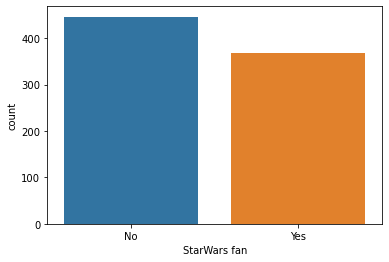

In [41]:
# visuele verdeling StarWars fan
sns.countplot(x='StarWars fan', data=dataset)

In [42]:
# statistische kerngetallen
dataset.describe()

,Please rank The Phantom Menace,Please rank attack of the clones,Please rank Revenge of the Sith,Plesase rank a new hope,Please rank The Empire Strikes Back,Please rank Return of the Jedi
count,813.000000,813.000000,813.000000,813.000000,813.000000,813.000000
mean,2.681427,2.981550,3.194342,2.490775,1.894219,2.241082
std,2.139383,2.126748,2.249601,2.190210,1.766862,1.981052
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.000000,4.000000,4.000000,2.000000,1.000000,2.000000
75%,4.000000,5.000000,5.000000,4.000000,3.000000,3.000000
max,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000


### Preprocessing en opsplitsen van de dataset

In [43]:
# verwijder kolom
dataset = dataset.drop(['Han Solo'],axis=1)
dataset = dataset.drop(['Luke Skywalker'],axis=1)
dataset = dataset.drop(['Princess Leia Organa'],axis=1)
dataset = dataset.drop(['Anakin Skywalker'],axis=1)
dataset = dataset.drop(['Obi Wan Kenobi'],axis=1)
dataset = dataset.drop(['Emperor Palpatine'],axis=1)
dataset = dataset.drop(['Darth Vader'],axis=1)
dataset = dataset.drop(['Lando Calrissian'],axis=1)
dataset = dataset.drop(['Boba Fett'],axis=1)
dataset = dataset.drop(['C-3P0'],axis=1)
dataset = dataset.drop(['R2 D2'],axis=1)
dataset = dataset.drop(['Jar Jar Binks'],axis=1)
dataset = dataset.drop(['Padme Amidala'],axis=1)
dataset = dataset.drop(['Yoda'],axis=1)

dataset = dataset.drop(['Which character shot first?'], axis=1)
# yes and no
dataset = pd.concat([dataset,pd.get_dummies(dataset['Have you seen any of the 6 films in the Star Wars franchise?'], prefix='seen movies')],axis=1)
dataset.drop(['Have you seen any of the 6 films in the Star Wars franchise?'],axis=1, inplace=True)
dataset = pd.concat([dataset,pd.get_dummies(dataset['Are you familiar with the Expanded Universe?'], prefix='familiar')],axis=1)
dataset.drop(['Are you familiar with the Expanded Universe?'],axis=1, inplace=True)
dataset = pd.concat([dataset,pd.get_dummies(dataset['Do you consider yourself to be a fan of the Expanded Universe?'], prefix='fan')],axis=1)
dataset.drop(['Do you consider yourself to be a fan of the Expanded Universe?'],axis=1, inplace=True)
dataset = pd.concat([dataset,pd.get_dummies(dataset['phantom menace seen'], prefix='phantom menace')],axis=1)
dataset.drop(['phantom menace seen'],axis=1, inplace=True)
dataset = pd.concat([dataset,pd.get_dummies(dataset['attack of the clones seen'], prefix='attack of the clones')],axis=1)
dataset.drop(['attack of the clones seen'],axis=1, inplace=True)
dataset = pd.concat([dataset,pd.get_dummies(dataset['revenge of the sith seen'], prefix='revenge of the sith')],axis=1)
dataset.drop(['revenge of the sith seen'],axis=1, inplace=True)
dataset = pd.concat([dataset,pd.get_dummies(dataset['a new hope seen'], prefix='a new hope seen')],axis=1)
dataset.drop(['a new hope seen'],axis=1, inplace=True)
dataset = pd.concat([dataset,pd.get_dummies(dataset['empire strikes back seen'], prefix='empire strikes back')],axis=1)
dataset.drop(['empire strikes back seen'],axis=1, inplace=True)
dataset = pd.concat([dataset,pd.get_dummies(dataset['return of the jedi seen'], prefix='return of the jedi')],axis=1)
dataset.drop(['return of the jedi seen'],axis=1, inplace=True)
dataset = pd.concat([dataset,pd.get_dummies(dataset['Gender'], prefix='gender')],axis=1)
dataset.drop(['Gender'],axis=1, inplace=True)
dataset = pd.concat([dataset,pd.get_dummies(dataset['Age'], prefix='age')],axis=1)
dataset.drop(['Age'],axis=1, inplace=True)
dataset = pd.concat([dataset,pd.get_dummies(dataset['Education'], prefix='education')],axis=1)
dataset.drop(['Education'],axis=1, inplace=True)
dataset = pd.concat([dataset,pd.get_dummies(dataset['Location'], prefix='location')],axis=1)
dataset.drop(['Location'],axis=1, inplace=True)

dataset['StarWars fan'] = dataset['StarWars fan'].map({'Yes': 1, 'No': 0})
dataset.head()

,Please rank The Phantom Menace,Please rank attack of the clones,Please rank Revenge of the Sith,Plesase rank a new hope,Please rank The Empire Strikes Back,Please rank Return of the Jedi,StarWars fan,seen movies_No,seen movies_Yes,familiar_No,...,education_Some college or Associate degree,location_East North Central,location_East South Central,location_Middle Atlantic,location_Mountain,location_New England,location_Pacific,location_South Atlantic,location_West North Central,location_West South Central
0,1.0,2.0,3.0,4.0,5.0,6.0,0,0,1,1,...,0,0,0,0,0,0,0,1,0,0
1,5.0,6.0,1.0,2.0,4.0,3.0,1,0,1,1,...,1,0,0,0,0,0,0,1,0,0
2,1.0,4.0,3.0,6.0,5.0,2.0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,1
3,4.0,5.0,6.0,3.0,2.0,1.0,1,0,1,1,...,0,0,0,0,0,0,0,0,1,0
4,1.0,2.0,3.0,4.0,5.0,6.0,0,0,1,1,...,1,0,0,1,0,0,0,0,0,0


Splits de dataset in **features en targets**.

In [44]:
# Opsplitsen in features en targets
X = dataset.drop(['StarWars fan'], axis=1).values
y = dataset['StarWars fan'].values


Creëer een **trainingset en een testset**. Zorg dat er 200 samples in de testset steken. 

In [45]:
# training set en test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=200, random_state=0)

**Schaal de dataset**

In [46]:
# Scaling
scaler = preprocessing.StandardScaler().fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)


### Trainen van een logistic regression classifier en testen van het bekomen model

Train een logistic regression classifier op de training data. Kies C=1 als startwaarde. Mocht de dataset niet gebalanceerd zijn (de ene klasse komt frequenter voor dan de andere klasse) dan kan je bij de creatie van het logistic regression model de parameter class_weight='balanced' meegeven. Meer info: http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

Test het getrainde model op de test set. Bepaal hierbij de confusion matrix, de accuracy en het classification report. Wat zijn de bevindingen? Probeer ook verschillende solvers uit. Bepaal ook telkens de ROC en formuleer conclusies.

Probeer de performantie van de classifier te verhogen door de parameter C te veranderen.

Evalueer de modellen telkens via de confusion matrix, classification report en indien mogelijk via de ROC-curve. Bespreek de resultaten.

In [47]:
# hyperparameter tuning model 1

logreg = linear_model.LogisticRegression(C=1, class_weight='balanced', solver='liblinear')
logreg.fit(X_train,y_train)
print('coefficiënten: ', logreg.coef_)
print('intercept:', logreg.intercept_)

coefficiënten:  [[ 0.51671008  0.56501925  0.13759786  0.06938857  0.04972594  0.0912938
  -0.30060335  0.30060335 -0.15877775  0.15877775 -0.24482165  0.24482165
  -0.08768068  0.08768068 -0.40115067  0.40115067 -0.04246331  0.04246331
  -0.23044855  0.23044855  0.01688332 -0.01688332 -0.19275664  0.19275664
   0.         -0.28109045 -0.11855573  0.09683639  0.24606933 -0.02321444
   0.0607538  -0.17829172 -0.24241786  0.14009632  0.08438163 -0.05249021
  -0.14255684 -0.0160873   0.05728108 -0.11561937  0.1166999   0.07348149
   0.01891996]]
intercept: [-1.00672012]


In [48]:
# testen van de logistic regression classifier 

y_pred = logreg.predict(X_test)

# classification report
print(classification_report(y_test, y_pred))
# accuracy
print(accuracy_score(y_test,y_pred)*100)
# confusion matrix
print(confusion_matrix(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.87      0.83      0.85       104
           1       0.82      0.86      0.84        96

    accuracy                           0.84       200
   macro avg       0.85      0.85      0.84       200
weighted avg       0.85      0.84      0.85       200

84.5
[[86 18]
 [13 83]]


- De precision bedraagt 87% voor klasse 0 en 82% voor klasse 1.


- De recall bedraagt 83% voor klasse 0 en 86% voor klasse 1. De recall is de percentage dat men ontdekt heeft van de klasse.


- Het gewogen gemiddelde van de recall en de precision is de F1 score. 
- De F1 bedraagt 85% voor klasse 0 en 84% voor klasse 1


- De accuracy bedraagt 84.5%, dit betekent dat in 84.5% gevallen de classifier correct is voorspelt.


Confusion matrix:
- De test set bedraagt in totaal 200 samples, dit kunnen we terug lezen in de support kolom. Vervolgens gaan we dit trainen om een voorspelling te maken.
- Diagonaal zijn er 2 waarden namelijk 86 (klasse 0) en 83 (klasse 1). In totaal bedraagt het 169 waarden die correct zijn voorspelt.
- 13 van de 200 samples is door het model voorspelt behorende tot klasse 0 , maar in werkelijkheid behorend tot klasse 1.
- 18 van de 200 samples is  door het model voorspelt behorende tot klasse 1, maar in werkelijkheid behorend tot klasse 0.

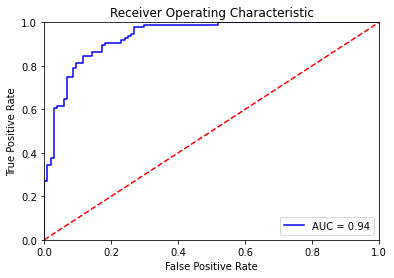

In [49]:
# ROC
# classifier te evalueren op eeng rafische methode
import sklearn.metrics as metrics
# calculate the fpr and tpr for all tresholds of the classification
probs = logreg.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


De AUC bedraagt 94%, dit is zeer goed. Hoe dichter de curve dichter komt bij ROC heaven, des te meer accuraat.

In [50]:
# hyperparameter tuning model 2
logreg = linear_model.LogisticRegression(C=0.2, class_weight='balanced', solver='liblinear')
logreg.fit(X_train,y_train)
print('coefficiënten: ', logreg.coef_)
print('intercept:', logreg.intercept_)

coefficiënten:  [[ 0.39418991  0.42848343  0.09657288 -0.01758368 -0.00183505  0.01982422
  -0.20635478  0.20635478 -0.1587089   0.1587089  -0.22932665  0.22932665
  -0.09900608  0.09900608 -0.36171639  0.36171639 -0.06971503  0.06971503
  -0.21850032  0.21850032 -0.02334764  0.02334764 -0.17747052  0.17747052
   0.         -0.24981793 -0.1056204   0.08733588  0.21765459 -0.02442811
   0.05969171 -0.16423781 -0.21421619  0.12612147  0.07913252 -0.04964202
  -0.13725435 -0.01656087  0.05379734 -0.10414533  0.10694611  0.0704885
   0.01839433]]
intercept: [-0.65914761]


In [51]:
# testen van de logistic regression classifier

y_pred = logreg.predict(X_test)

# classification report
print(classification_report(y_test, y_pred))
# accuracy
print(accuracy_score(y_test,y_pred)*100)
# confusion matrix
print(confusion_matrix(y_test,y_pred))


              precision    recall  f1-score   support

           0       0.89      0.84      0.86       104
           1       0.83      0.89      0.86        96

    accuracy                           0.86       200
   macro avg       0.86      0.86      0.86       200
weighted avg       0.86      0.86      0.86       200

86.0
[[87 17]
 [11 85]]


- De precision bedraagt 89% voor klasse 0 en 83% voor klasse 1.


- De recall bedraagt 84% voor klasse 0 en 89% voor klasse 1. De recall is de percentage dat men ontdekt heeft van de klasse.


- Het gewogen gemiddelde van de recall en de precision is de F1 score. 
- De F1 bedraagt 86% voor klasse 0 en 86% voor klasse 1


- De accuracy bedraagt 86%, dit betekent dat in 86% gevallen de classifier correct is voorspelt.


Confusion matrix:
- De test set bedraagt in totaal 200 samples, dit kunnen we terug lezen in de support kolom. Vervolgens gaan we dit trainen om een voorspelling te maken.
- Diagonaal zijn er 2 waarden namelijk 87 (klasse 0) en 85 (klasse 1). In totaal bedraagt het 172 waarden die correct zijn voorspelt.
- 11 van de 200 samples is door het model voorspelt behorende tot klasse 0 , maar in werkelijkheid behorend tot klasse 1.
- 17 van de 200 samples is  door het model voorspelt behorende tot klasse 1, maar in werkelijkheid behorend tot klasse 0.

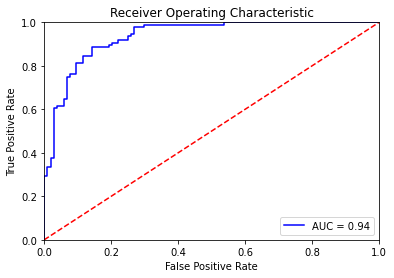

In [52]:
# ROC
# classifier te evalueren op eeng rafische methode
import sklearn.metrics as metrics
# calculate the fpr and tpr for all tresholds of the classification
probs = logreg.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

De AUC bedraagt 94%, dit is zeer goed. Hoe dichter de curve dichter komt bij ROC heaven, des te meer accuraat.

Het model is verbeterd bij het veranderen van de C parameter. Een lichte stijging van 196 naar 172 correcte voorspelde waarden. Vervolgens is de accuracy ook verbeterd met 1.5% en doet het model goed.

## Opdracht 4. Menselijke activiteit


De dataset 'activiteit.csv' bevat meetgegevens die van 30 personen via een smartphone werden afgenomen. Deze meetwaarden zijn onderandere afkomstig van een accelerometer en een gyroscoop die in de smartphone zijn ingebouwd.
De bedoeling is om om basis van deze meetwaarden de activiteit van de persoon zo nauwkeurig mogelijk te kunnen inschatten.
Er zijn 6 verschillende klasses.


Bepaal de 6 verschillende klasses en onderzoek meteen of de dataset gebalanceerd is (gelijkmatige verdeling van de verschillende klasses).
Bouw een logistic regression model dat zo accuraat mogelijk de activiteit van de persoon kan bepalen. Hierbij pas je alle nodige preprocessing stappen toe je nodig acht.
Het is ook toegestaann om features bij te maken of weg te laten. 

Schrijf jouw conclusies op met betrekking tot het finaal bekomen model.




### Inlezen van de dataset en vooranalyse

In [53]:
dataset = pd.read_csv('activiteit.csv')
dataset.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject,Activity
0,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,-0.923527,-0.934724,...,-0.710304,-0.112754,0.030400,-0.464761,-0.018446,-0.841247,0.179941,-0.058627,1,STANDING
1,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,-0.957686,-0.943068,...,-0.861499,0.053477,-0.007435,-0.732626,0.703511,-0.844788,0.180289,-0.054317,1,STANDING
2,0.279653,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,-0.977469,-0.938692,...,-0.760104,-0.118559,0.177899,0.100699,0.808529,-0.848933,0.180637,-0.049118,1,STANDING
3,0.279174,-0.026201,-0.123283,-0.996091,-0.983403,-0.990675,-0.997099,-0.982750,-0.989302,-0.938692,...,-0.482845,-0.036788,-0.012892,0.640011,-0.485366,-0.848649,0.181935,-0.047663,1,STANDING
4,0.276629,-0.016570,-0.115362,-0.998139,-0.980817,-0.990482,-0.998321,-0.979672,-0.990441,-0.942469,...,-0.699205,0.123320,0.122542,0.693578,-0.615971,-0.847865,0.185151,-0.043892,1,STANDING


In [54]:
# inconsistenties opsporen
dataset.isnull().sum()
# dataset.isna().any().any()
# neen, er zijn geen ontbrekende waarden

tBodyAcc-mean()-X       0
tBodyAcc-mean()-Y       0
tBodyAcc-mean()-Z       0
tBodyAcc-std()-X        0
tBodyAcc-std()-Y        0
                       ..
angle(X,gravityMean)    0
angle(Y,gravityMean)    0
angle(Z,gravityMean)    0
subject                 0
Activity                0
Length: 563, dtype: int64

Neen, er zijn geen ontbrekende waarden

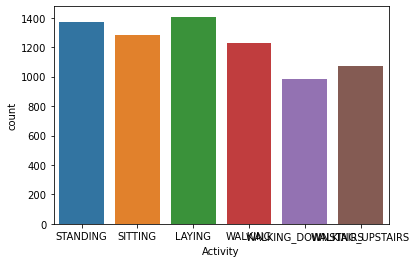

In [55]:
# visuele verdeling activity 
sns.countplot(x='Activity', data=dataset)

De 6 klasses zijn:
    - Standing
    - Sitting
    - Laying
    - Walking
    - Walking downstairs
    - Walking upstairs

In [56]:
# gebalanceerdheid controleren
standing = dataset.loc[dataset['Activity'] == 'STANDING'].count()
sitting = dataset.loc[dataset['Activity'] == 'SITTING'].count()
laying = dataset.loc[dataset['Activity'] == 'LAYING'].count()
walking = dataset.loc[dataset['Activity'] == 'WALKING'].count()
walkingDownstairs = dataset.loc[dataset['Activity'] == 'WALKING_DOWNSTAIRS'].count()
walkingUpstairs = dataset.loc[dataset['Activity'] == 'WALKING_UPSTAIRS'].count()
print(standing)
print(sitting)
print(laying)
print(walking)
print(walkingDownstairs)
print(walkingUpstairs)

tBodyAcc-mean()-X       1374
tBodyAcc-mean()-Y       1374
tBodyAcc-mean()-Z       1374
tBodyAcc-std()-X        1374
tBodyAcc-std()-Y        1374
                        ... 
angle(X,gravityMean)    1374
angle(Y,gravityMean)    1374
angle(Z,gravityMean)    1374
subject                 1374
Activity                1374
Length: 563, dtype: int64
tBodyAcc-mean()-X       1286
tBodyAcc-mean()-Y       1286
tBodyAcc-mean()-Z       1286
tBodyAcc-std()-X        1286
tBodyAcc-std()-Y        1286
                        ... 
angle(X,gravityMean)    1286
angle(Y,gravityMean)    1286
angle(Z,gravityMean)    1286
subject                 1286
Activity                1286
Length: 563, dtype: int64
tBodyAcc-mean()-X       1407
tBodyAcc-mean()-Y       1407
tBodyAcc-mean()-Z       1407
tBodyAcc-std()-X        1407
tBodyAcc-std()-Y        1407
                        ... 
angle(X,gravityMean)    1407
angle(Y,gravityMean)    1407
angle(Z,gravityMean)    1407
subject                 1407
Activity            

- standing: 1374
- sitting: 1286
- laying: 1407
- walking: 1226
- walking down: 986
- walking upstairs: 1073

We kunnen besluiten dat de dataset niet gebalanceerd is. Het laagste van de 6 klasses heeft 986 waarden, terwijl het hoogste 1407 waarden heeft.

In [57]:
# statistische kerngetallen
dataset.describe()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject
count,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,...,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000
mean,0.274488,-0.017695,-0.109141,-0.605438,-0.510938,-0.604754,-0.630512,-0.526907,-0.606150,-0.468604,...,-0.307009,-0.625294,0.008684,0.002186,0.008726,-0.005981,-0.489547,0.058593,-0.056515,17.413085
std,0.070261,0.040811,0.056635,0.448734,0.502645,0.418687,0.424073,0.485942,0.414122,0.544547,...,0.321011,0.307584,0.336787,0.448306,0.608303,0.477975,0.511807,0.297480,0.279122,8.975143
min,-1.000000,-1.000000,-1.000000,-1.000000,-0.999873,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-0.995357,-0.999765,-0.976580,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,1.000000
25%,0.262975,-0.024863,-0.120993,-0.992754,-0.978129,-0.980233,-0.993591,-0.978162,-0.980251,-0.936219,...,-0.542602,-0.845573,-0.121527,-0.289549,-0.482273,-0.376341,-0.812065,-0.017885,-0.143414,8.000000
50%,0.277193,-0.017219,-0.108676,-0.946196,-0.851897,-0.859365,-0.950709,-0.857328,-0.857143,-0.881637,...,-0.343685,-0.711692,0.009509,0.008943,0.008735,-0.000368,-0.709417,0.182071,0.003181,19.000000
75%,0.288461,-0.010783,-0.097794,-0.242813,-0.034231,-0.262415,-0.292680,-0.066701,-0.265671,-0.017129,...,-0.126979,-0.503878,0.150865,0.292861,0.506187,0.359368,-0.509079,0.248353,0.107659,26.000000
max,1.000000,1.000000,1.000000,1.000000,0.916238,1.000000,1.000000,0.967664,1.000000,1.000000,...,0.989538,0.956845,1.000000,1.000000,0.998702,0.996078,1.000000,0.478157,1.000000,30.000000


### Preprocessing en opsplitsen van de dataset

Splits de dataset in **features en targets**.

In [58]:
# Opsplitsen in features en targets
X = dataset.drop(['Activity'], axis=1).values
y = dataset['Activity'].values
print(X)
print(y)

[[ 2.8858451e-01 -2.0294171e-02 -1.3290514e-01 ...  1.7994061e-01
  -5.8626924e-02  1.0000000e+00]
 [ 2.7841883e-01 -1.6410568e-02 -1.2352019e-01 ...  1.8028889e-01
  -5.4316717e-02  1.0000000e+00]
 [ 2.7965306e-01 -1.9467156e-02 -1.1346169e-01 ...  1.8063731e-01
  -4.9117815e-02  1.0000000e+00]
 ...
 [ 2.7338737e-01 -1.7010616e-02 -4.5021828e-02 ...  2.4914484e-01
   4.0811188e-02  3.0000000e+01]
 [ 2.8965416e-01 -1.8843044e-02 -1.5828059e-01 ...  2.4643223e-01
   2.5339478e-02  3.0000000e+01]
 [ 3.5150347e-01 -1.2423118e-02 -2.0386717e-01 ...  2.4680852e-01
   3.6694843e-02  3.0000000e+01]]
['STANDING' 'STANDING' 'STANDING' ... 'WALKING_UPSTAIRS'
 'WALKING_UPSTAIRS' 'WALKING_UPSTAIRS']


Creëer een **trainingset en een testset**. 30% test set

In [59]:
# training set en test set (30%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

**Schaal de dataset**

In [60]:
# Scaling
scaler = preprocessing.StandardScaler().fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

### Trainen van een logistic regression classifier en testen van het bekomen model

Train een logistic regression classifier op de training data. Kies C=1 als startwaarde. Mocht de dataset niet gebalanceerd zijn (de ene klasse komt frequenter voor dan de andere klasse) dan kan je bij de creatie van het logistic regression model de parameter class_weight='balanced' meegeven. Meer info: http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

Test het getrainde model op de test set. Bepaal hierbij de confusion matrix, de accuracy en het classification report. Wat zijn de bevindingen? Probeer ook verschillende solvers uit. Bepaal ook telkens de ROC en formuleer conclusies.

Probeer de performantie van de classifier te verhogen door de parameter C te veranderen.

Evalueer de modellen telkens via de confusion matrix, classification report en indien mogelijk via de ROC-curve. Bespreek de resultaten.

In [61]:
# hyperparameter tuning model 1
logreg = linear_model.LogisticRegression(C=1 , class_weight='balanced',solver='liblinear')
logreg.fit(X_train,y_train)
print('coefficiënten: ', logreg.coef_)
print('intercept:', logreg.intercept_)

coefficiënten:  [[-0.06924283 -0.08183049 -0.02150646 ... -0.25923779 -0.10454829
  -0.06723806]
 [ 0.13004624 -0.13865569 -0.13890198 ... -1.0483544  -0.02539282
   0.27737829]
 [ 0.09365262  0.09983999  0.10467831 ...  0.72194332 -0.50123058
  -0.41338304]
 [-0.0644012   0.0060623   0.10974663 ... -0.15596741 -0.09136107
   0.09359475]
 [ 0.34141713  0.24888133  0.15558061 ... -0.2300045   0.0318009
   0.13233112]
 [-0.22689762 -0.21790371 -0.30355352 ...  0.46660066  0.10755796
   0.01609058]]
intercept: [-4.03954649 -6.55396755 -6.88984177 -5.76847151 -5.51209333 -6.35377423]


In [62]:
# testen van de logistic regression classifier

y_pred = logreg.predict(X_test)

# classification report
print(classification_report(y_test, y_pred))
# accuracy
print(accuracy_score(y_test,y_pred)*100)
# confusion matrix
print(confusion_matrix(y_test,y_pred))


                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       435
           SITTING       0.97      0.96      0.96       406
          STANDING       0.96      0.97      0.96       409
           WALKING       1.00      1.00      1.00       361
WALKING_DOWNSTAIRS       1.00      1.00      1.00       280
  WALKING_UPSTAIRS       1.00      1.00      1.00       315

          accuracy                           0.99      2206
         macro avg       0.99      0.99      0.99      2206
      weighted avg       0.99      0.99      0.99      2206

98.50407978241161
[[435   0   0   0   0   0]
 [  0 388  18   0   0   0]
 [  0  14 395   0   0   0]
 [  0   0   0 360   0   1]
 [  0   0   0   0 280   0]
 [  0   0   0   0   0 315]]


- In het algemeen zijn de precision, recall en f1-score hoog met een minimum van 96%


- De accuracy bedraagt 98%, dit betekent dat in 98% gevallen de classifier correct is voorspelt.


Confusion matrix:
- De test set bedraagt in totaal 2206 samples, dit kunnen we terug lezen in de support kolom. Vervolgens gaan we dit trainen om een voorspelling te maken.
- Diagonaal zijn er 6 waarden namelijk 435 (klasse 0), 388 (klasse 1), 395 (klasse 2), 360 (klasse 3), 280 (klasse 4), 315 (klasse 5). In totaal bedraagt het 2173 waarden die correct zijn voorspelt.
- 1 van de 2206 samples is door het model voorspelt behorende tot klasse 5, maar in werkelijkheid behorend tot klasse 3.

In [63]:
# hyperparameter tuning model 2
logreg = linear_model.LogisticRegression(C=10 , class_weight='balanced',solver='liblinear')
logreg.fit(X_train,y_train)
print('coefficiënten: ', logreg.coef_)
print('intercept:', logreg.intercept_)

coefficiënten:  [[-0.11133904 -0.11399577 -0.02415246 ... -0.29236978 -0.12112557
  -0.0912077 ]
 [ 0.31302654 -0.35026814 -0.34140475 ... -1.6863577   0.12367558
   0.51787401]
 [ 0.45171934  0.34669766  0.09577893 ...  1.21117457 -1.08185801
  -0.73159995]
 [-0.07617252 -0.01377153  0.17906865 ... -0.24407234 -0.13140837
   0.10718878]
 [ 0.48216568  0.35437155  0.25363031 ... -0.36439038  0.04156368
   0.21829086]
 [-0.33183732 -0.24397552 -0.39104725 ...  0.76971544  0.18163616
   0.05207463]]
intercept: [ -5.33539533 -12.35745594 -13.45812299  -8.0975637   -7.68180305
  -9.37272435]


In [64]:
# testen van de logistic regression classifier

y_pred = logreg.predict(X_test)

# classification report
print(classification_report(y_test, y_pred))
# accuracy
print(accuracy_score(y_test,y_pred)*100)
# confusion matrix
print(confusion_matrix(y_test,y_pred))


                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       435
           SITTING       0.96      0.96      0.96       406
          STANDING       0.96      0.96      0.96       409
           WALKING       1.00      1.00      1.00       361
WALKING_DOWNSTAIRS       1.00      1.00      1.00       280
  WALKING_UPSTAIRS       1.00      1.00      1.00       315

          accuracy                           0.99      2206
         macro avg       0.99      0.99      0.99      2206
      weighted avg       0.99      0.99      0.99      2206

98.50407978241161
[[435   0   0   0   0   0]
 [  0 389  17   0   0   0]
 [  0  15 394   0   0   0]
 [  0   0   0 360   0   1]
 [  0   0   0   0 280   0]
 [  0   0   0   0   0 315]]


Aan de hand van de confusion matrix kan ik besluiten dat het model ideaal doet met het maken van de voorspellingen. Alle klasses doen het uitstekend voor de precision, recall en f1-score. Hetzelfde geldt voor de accuracy. Om eventueel het model te verbeteren heb ik een 2de model opgesteld. Helaas kom ik niet uit op een beter model daarom is het 1ste model de voorkeur. 